In [26]:
#cp ../rmcclure/procedure.py .

In [1]:
import numpy as np 
import pickle
from superfreq import SuperFreq
from matplotlib import pyplot as plt
from galpy.util import bovy_coords as coords
import gala.dynamics as gd
import astropy.units as u
import gala.coordinates as gc
import os
import sys
from procedure import *
import pandas as pd

/mnt/home/bbhattarai/.local/lib/python3.7/site-packages/galpy/util/bovy_coords.py:6: FutureWarning: galpy.util.bovy_coords is being deprecated in favor of galpy.util.coords; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9
  warnings.warn('galpy.util.bovy_coords is being deprecated in favor of galpy.util.coords; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9',FutureWarning)

start at: 2021-08-05 13:01:47.359371
end at: 2021-08-05 13:01:47.360801


In [2]:
!pwd

/mnt/home/bbhattarai


In [3]:
times=np.genfromtxt(path+'times.txt',dtype='str')
print("Total snapshots present is",len(times))
snapshot_start=0
snapshot_end=len(times)

Total snapshots present is 1265


In [4]:
!hostname

pcn-9-59


In [5]:
plotpath="/mnt/home/bbhattarai/resonance_sweeping/New_Sims_Analysis/plots/"

In [6]:
snapshot=1000
snaparr = loadwholesnap(path,snapshot)
print("These are the data we have",snaparr[0].dtype)
idd=snaparr['idd']
x=snaparr['x']
y=snaparr['y']
z=snaparr['z']
vx=snaparr['vx']
vy=snaparr['vy']
vz=snaparr['vz']  
mass=snaparr['mass']  #mass is in solar mass (change old mass calculations to take account of the factor 2.324876e9)

vr=snaparr['vr']
vphi=snaparr['vphi']
vzz=snaparr['vzz']
r=snaparr['r']
phi=snaparr['phi'] #phi is in radians
zz=snaparr['zz']

#converting phi to degrees
phi_degrees=np.rad2deg(phi)

These are the data we have [('t', '<f8'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4'), ('vr', '<f4'), ('vphi', '<f4'), ('vzz', '<f4'), ('r', '<f4'), ('phi', '<f4'), ('zz', '<f4'), ('mass', '<f4'), ('idd', '<u8')]


# Selecting the solar neighborhood

In [10]:
keep_sn=(x<8.2)*(x>7.8)*(y<0.5)*(y>-0.5)*(z<0.5)*(z>-0.5)

In [8]:
np.sum(keep_sn)

69260

In [9]:
freq_path="/mnt/home/bbhattarai/resonance_sweeping/New_Sims_Analysis/freq_data/"

column=["t", "omega_r","omega_phi","omega_z"] #column to store the data

idd_keep=idd[keep_sn] #narrowing the particle ids to solar neighborhood only
ndim=6 # dimension of phase space
keep_small=idd_keep[1000:1001] #selecting a group of 15 particles for test, change it 

for i in range(len(keep_small)):
    
    test_particle=keep_small[i]  #test paticle to look at
    df = pd.DataFrame(columns=column)
    for j in range(40,1040,40):
        #print("looking orbits of particle:",i)
        
        test = loadonesource(path,test_particle,start=j-40,finish=j+40) # do it for 200 Myr
        
        #calculate frequencies every 200 Myrs (0-200, 200-400, 400-600, 600-800 in time (Myrs)) (0-40. 40-80..... in snapshots)
        x_test=test['x'].astype(np.float64)
        y_test=test['y'].astype(np.float64)
        z_test=test['z'].astype(np.float64)
        vx_test=test['vx'].astype(np.float64)
        vy_test=test['vy'].astype(np.float64)
        vz_test=test['vz'].astype(np.float64)
        vphi_test=test['vphi'].astype(np.float64)
        mass_test=test['mass'].astype(np.float64)
        r_test=test['r'].astype(np.float64)
        t=test['t'].astype(np.float64)

        w1 = gd.Orbit(
            pos=[x_test,y_test,z_test] * u.kpc,
            vel=[vx_test,vy_test,vz_test] * u.km/u.s,
            t=t*u.Gyr
        )

        w=w1.w([u.kpc,u.Gyr,u.Msun])
        ntimes= w1.shape
        
        vphi_signs=np.sum(np.sign(vphi_test))
        if (abs(vphi_signs))==len(vphi_test): # Lz= vphi*r so checking of vphi is enough
            pp = gc.cartesian_to_poincare_polar(w1.w([u.kpc,u.Gyr,u.Msun]).T).T # use it if we have loop orbits i.e if Lz doesn't change sign
            sf = SuperFreq(t)
            fs = [(pp[i] * 1j*pp[i+ndim//2]) for i in range(ndim//2)] #when using pp

        else:
            sf = SuperFreq(t)
            fs = [(w[i] * 1j*w[i+ndim//2]) for i in range(ndim//2)]   #without using pp
        #fs = [(w[i] * 1j*w[i+ndim//2]) for i in range(ndim//2)]   #without using pp

        result = sf.find_fundamental_frequencies(fs)
        freqs = result.fund_freqs
        row=[float(times[j-20][11:-2])/1000*9.778145,freqs[0],freqs[1],freqs[2]]
        row_data = pd.Series(row, index = df.columns)
        df = df.append(row_data, ignore_index=True)
        #print("Done: ",freqs)
    file_name="particle_"+str(i)+"_freqs_400Myr_range_with_pp_rolling_window.csv"
    df.to_csv(freq_path+file_name, encoding='utf-8', index=False)
    del df



# testing the sign of v_phi

In [18]:
print(idd_keep)

[116053017 212224727 176788202 ... 164245189 164121358  47710709]


ATTN: Enabled km/s units instead of 100km/s for velocities.
[('t', '<f8'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4'), ('vr', '<f4'), ('vphi', '<f4'), ('vzz', '<f4'), ('r', '<f4'), ('phi', '<f4'), ('zz', '<f4'), ('mass', '<f4'), ('idd', '<u8')]


Text(0.5, 1.0, 'vx')

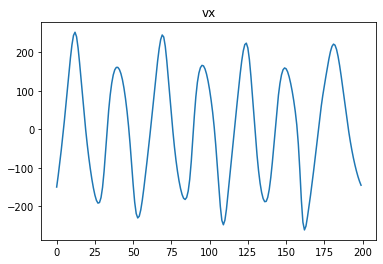

In [22]:
test_data = loadonesource(path,176788202,start=0,finish=200)

print(test_data.dtype)
vphi_t=test_data['vphi'].astype(np.float64)
vx_t=test_data['vx'].astype(np.float64)
plt.plot(vx_t)
plt.title("vx")


In [23]:
print(test_particle)

224229408


# Plotting frequencies

In [24]:
filenames=["particle_"+str(f)+"_freqs_400Myr_range_with_pp_rolling_window.csv" for f in range(0,1)]
df_r=pd.read_csv(freq_path+filenames[0])


In [29]:
df_r.head()

,t,omega_r,omega_phi,omega_z
0,0.100006,-65.995771,66.119386,160.347627
1,0.300001,72.089522,73.093753,170.598735
2,0.500010,-84.098392,82.576654,-203.598305
3,0.700011,-105.182446,-73.306476,-276.431960
4,0.900010,-61.413901,-64.518034,143.261724


Plot generated and saved to file:  particle_0_freqs_over_time_400Myr_range_with_pp_abs_rolling_window.jpg


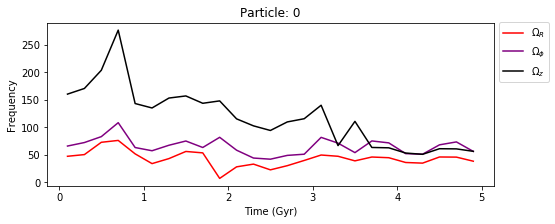

In [25]:
for i in range(1):
    df_r=pd.read_csv(freq_path+filenames[i])
    fig1=plt.figure(figsize=(8,3))
    ax=fig1.add_subplot(111)
    #ax.plot(df_r.t,df_r.omega_r,c='red',label="$\omega$$_R$")
    #ax.plot(df_r.t,df_r.omega_phi,c='purple',label="$\omega$$_$\phi$$")
    #ax.plot(df_r.t,df_r.omega_z,c="black",label="v$\omega$R")
    #ax.text(4,200,"Particle: "+str(i))
    ax.set_title("Particle: "+str(i))
    ax.plot(df_r.t,abs(df_r.omega_r),c='red',label="$\Omega$$_R$")
    ax.plot(df_r.t,abs(df_r.omega_phi),c='purple',label="$\Omega$$_\phi$")
    ax.plot(df_r.t,abs(df_r.omega_z),c="black",label="$\Omega$$_z$")
    ax.legend(bbox_to_anchor=(1.00,0.82), loc='center left',markerscale=9)
    ax.set_xlabel("Time (Gyr)")
    #ax.set_xlim(0,2)
    ax.set_ylabel(r"Frequency")
    plotname="particle_"+str(i)+"_freqs_over_time_400Myr_range_with_pp_abs_rolling_window.jpg"
    fig1.savefig(plotpath+plotname,bbox_inches="tight",dpi=150)
    print("Plot generated and saved to file: ",plotname)
    #plt.show()

# Adjusting the p value

Plot generated and saved to file:  particle_40_freqs_over_time_200Myr_range_with_pp_abs_rolling_window_p1.jpg


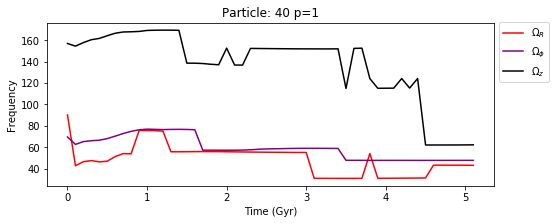

In [40]:
column=["t", "omega_r","omega_phi","omega_z"] #column to store the data

ndim=6 # dimension of phase space
p=1
test_particle=224229408
df = pd.DataFrame(columns=column)
for j in range(0,1040,20):

    test = loadonesource(path,test_particle,start=0,finish=j+20) # do it for 200 Myr
    #calculate frequencies every 200 Myrs (0-200, 200-400, 400-600, 600-800 in time (Myrs)) (0-40. 40-80..... in snapshots)
    x_test=test['x'].astype(np.float64)
    y_test=test['y'].astype(np.float64)
    z_test=test['z'].astype(np.float64)
    vx_test=test['vx'].astype(np.float64)
    vy_test=test['vy'].astype(np.float64)
    vz_test=test['vz'].astype(np.float64)
    vphi_test=test['vphi'].astype(np.float64)
    mass_test=test['mass'].astype(np.float64)
    r_test=test['r'].astype(np.float64)
    t=test['t'].astype(np.float64)

    w1 = gd.Orbit(
        pos=[x_test,y_test,z_test] * u.kpc,
        vel=[vx_test,vy_test,vz_test] * u.km/u.s,
        t=t*u.Gyr
    )

    w=w1.w([u.kpc,u.Gyr,u.Msun])
    ntimes= w1.shape
    
    vphi_signs=np.sum(np.sign(vphi_test))
    if (abs(vphi_signs))==len(vphi_test): # Lz= vphi*r so checking of vphi is enough
        pp = gc.cartesian_to_poincare_polar(w1.w([u.kpc,u.Gyr,u.Msun]).T).T # use it if we have loop orbits i.e if Lz doesn't change sign
        sf = SuperFreq(t,p)
        fs = [(pp[i] * 1j*pp[i+ndim//2]) for i in range(ndim//2)] #when using pp

    else:
        sf = SuperFreq(t,p)
        fs = [(w[i] * 1j*w[i+ndim//2]) for i in range(ndim//2)]   #without using pp
    #fs = [(w[i] * 1j*w[i+ndim//2]) for i in range(ndim//2)]   #without using pp

    result = sf.find_fundamental_frequencies(fs)
    freqs = result.fund_freqs
    row=[float(times[j][11:-2])/1000*9.778145,freqs[0],freqs[1],freqs[2]]
    row_data = pd.Series(row, index = df.columns)
    df = df.append(row_data, ignore_index=True)
    #print("Done: ",freqs)


fig1=plt.figure(figsize=(8,3))
ax=fig1.add_subplot(111)
#ax.plot(df.t,df.omega_r,c='red',label="$\omega$$_R$")
#ax.plot(df.t,df.omega_phi,c='purple',label="$\omega$$_$\phi$$")
#ax.plot(df.t,df.omega_z,c="black",label="v$\omega$R")
#ax.text(4,200,"Particle: "+str(i))
ax.set_title("Particle: "+str(i)+ " p="+str(p))
ax.plot(df.t,abs(df.omega_r),c='red',label="$\Omega$$_R$")
ax.plot(df.t,abs(df.omega_phi),c='purple',label="$\Omega$$_\phi$")
ax.plot(df.t,abs(df.omega_z),c="black",label="$\Omega$$_z$")
ax.legend(bbox_to_anchor=(1.00,0.82), loc='center left',markerscale=9)
ax.set_xlabel("Time (Gyr)")
#ax.set_xlim(0,2)
ax.set_ylabel(r"Frequency")
plotname="particle_"+str(i)+"_freqs_over_time_200Myr_range_with_pp_abs_rolling_window_p"+str(p)+".jpg"
fig1.savefig(plotpath+plotname,bbox_inches="tight",dpi=150)
print("Plot generated and saved to file: ",plotname)
#plt.show()




In [26]:
print(df)

           t    omega_r  omega_phi     omega_z
0   5.840064  42.759263 -62.669986  154.344889
1   0.100006  47.556100 -66.124958  160.347627
2   0.300001  46.994830  68.066075  164.077295
3   0.500010  54.026854  72.818236  167.547044
4   0.700011  75.567452  76.283927  168.063169
5   0.900010  75.454712  76.685246  169.199954
6   1.100010 -55.798996 -76.632966  169.259396
7   1.300015  55.845441  76.616763  138.474564
8   1.500015  55.942885  57.302501 -138.125796
9   1.700006  55.886110  57.236883 -136.972719
10  1.900006  55.693972 -57.249334  136.710317
11  2.100006 -55.520684 -57.610750  152.224860
12  2.299997  55.376808 -58.420005 -152.066456
13  2.499997 -55.258282 -58.733860  151.931187
14  2.700006 -55.159214  58.958655  151.828896
15  2.900006 -31.028049  59.004789 -151.780203
16  3.100016  30.974975  58.947112  151.768059
17  3.300016  30.956917  47.833920 -114.883047
18  3.500017 -30.984869 -47.782987  152.451333
19  3.700027 -31.038321 -47.757392 -115.019169
20  3.900027 

# Adjusting p value for rolling windows

Plot generated and saved to file:  particle_0_400Myr_range_abs_rolling_window_p3.jpg


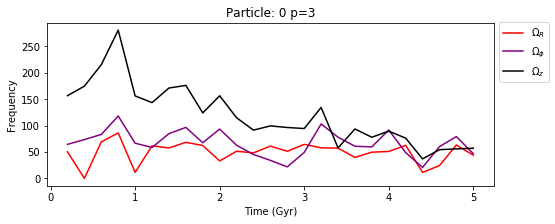

In [13]:
column=["t", "omega_r","omega_phi","omega_z"] #column to store the data

ndim=6 # dimension of phase space
p=3
test_particle=224229408
df = pd.DataFrame(columns=column)
for j in range(40,1040,40):

    test = loadonesource(path,test_particle,start=j-20,finish=j+20) # do it for 200 Myr
    #calculate frequencies every 200 Myrs (0-200, 200-400, 400-600, 600-800 in time (Myrs)) (0-40. 40-80..... in snapshots)
    x_test=test['x'].astype(np.float64)
    y_test=test['y'].astype(np.float64)
    z_test=test['z'].astype(np.float64)
    vx_test=test['vx'].astype(np.float64)
    vy_test=test['vy'].astype(np.float64)
    vz_test=test['vz'].astype(np.float64)
    vphi_test=test['vphi'].astype(np.float64)
    mass_test=test['mass'].astype(np.float64)
    r_test=test['r'].astype(np.float64)
    t=test['t'].astype(np.float64)

    w1 = gd.Orbit(
        pos=[x_test,y_test,z_test] * u.kpc,
        vel=[vx_test,vy_test,vz_test] * u.km/u.s,
        t=t*u.Gyr
    )

    w=w1.w([u.kpc,u.Gyr,u.Msun])
    ntimes= w1.shape
    
    vphi_signs=np.sum(np.sign(vphi_test))
    if (abs(vphi_signs))==len(vphi_test): # Lz= vphi*r so checking of vphi is enough
        pp = gc.cartesian_to_poincare_polar(w1.w([u.kpc,u.Gyr,u.Msun]).T).T # use it if we have loop orbits i.e if Lz doesn't change sign
        sf = SuperFreq(t,p)
        fs = [(pp[i] * 1j*pp[i+ndim//2]) for i in range(ndim//2)] #when using pp

    else:
        sf = SuperFreq(t,p)
        fs = [(w[i] * 1j*w[i+ndim//2]) for i in range(ndim//2)]   #without using pp
    #fs = [(w[i] * 1j*w[i+ndim//2]) for i in range(ndim//2)]   #without using pp

    result = sf.find_fundamental_frequencies(fs)
    freqs = result.fund_freqs
    row=[float(times[j][11:-2])/1000*9.778145,freqs[0],freqs[1],freqs[2]]
    row_data = pd.Series(row, index = df.columns)
    df = df.append(row_data, ignore_index=True)
    #print("Done: ",freqs)


fig1=plt.figure(figsize=(8,3))
ax=fig1.add_subplot(111)
#ax.plot(df.t,df.omega_r,c='red',label="$\omega$$_R$")
#ax.plot(df.t,df.omega_phi,c='purple',label="$\omega$$_$\phi$$")
#ax.plot(df.t,df.omega_z,c="black",label="v$\omega$R")
#ax.text(4,200,"Particle: "+str(i))
ax.set_title("Particle: "+str(i)+ " p="+str(p))
ax.plot(df.t,abs(df.omega_r),c='red',label="$\Omega$$_R$")
ax.plot(df.t,abs(df.omega_phi),c='purple',label="$\Omega$$_\phi$")
ax.plot(df.t,abs(df.omega_z),c="black",label="$\Omega$$_z$")
ax.legend(bbox_to_anchor=(1.00,0.82), loc='center left',markerscale=9)
ax.set_xlabel("Time (Gyr)")
#ax.set_xlim(0,2)
ax.set_ylabel(r"Frequency")
plotname="particle_"+str(i)+"_400Myr_range_abs_rolling_window_p"+str(p)+".jpg"
fig1.savefig(plotpath+plotname,bbox_inches="tight",dpi=150)
print("Plot generated and saved to file: ",plotname)
#plt.show()


Plot generated and saved to file:  particle_176788202particle_at_700_around_that_region3.jpg
        t    omega_r  omega_phi     omega_z
0    25.0 -36.386504  24.374803   99.245178
1    50.0  38.113872  55.234907  102.330712
2    75.0 -39.872642 -59.133733  104.086376
3   100.0  40.843025 -60.107291  104.696455
4   125.0 -41.697782 -61.066905 -105.591311
5   150.0 -42.432744 -61.229890  106.178221
6   175.0  42.965215  60.512891  106.205583
7   200.0 -43.289553  59.572826  105.938787
8   225.0  43.467432  58.973867  105.533787
9   250.0 -43.556479  58.606876  105.063498
10  275.0  43.590453 -58.349458  118.618010
11  300.0 -43.585048 -58.152290  104.353128
12  325.0  43.545743  57.985268 -104.099912


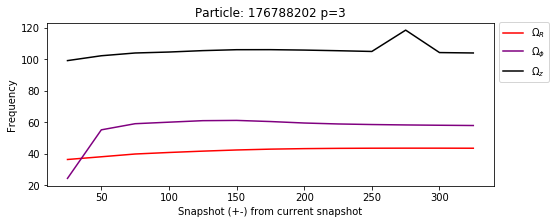

In [29]:
column=["t", "omega_r","omega_phi","omega_z"] #column to store the data

ndim=6 # dimension of phase space
p=3
test_particle=176788202
df = pd.DataFrame(columns=column)
snapshot=700
for j in range(1,14,1):
    factor=j*25
    test = loadonesource(path,test_particle,start=snapshot-factor,finish=snapshot+factor) # do it for 200 Myr
    #calculate frequencies every 200 Myrs (0-200, 200-400, 400-600, 600-800 in time (Myrs)) (0-40. 40-80..... in snapshots)
    x_test=test['x'].astype(np.float64)
    y_test=test['y'].astype(np.float64)
    z_test=test['z'].astype(np.float64)
    vx_test=test['vx'].astype(np.float64)
    vy_test=test['vy'].astype(np.float64)
    vz_test=test['vz'].astype(np.float64)
    vphi_test=test['vphi'].astype(np.float64)
    mass_test=test['mass'].astype(np.float64)
    r_test=test['r'].astype(np.float64)
    t=test['t'].astype(np.float64)

    w1 = gd.Orbit(
        pos=[x_test,y_test,z_test] * u.kpc,
        vel=[vx_test,vy_test,vz_test] * u.km/u.s,
        t=t*u.Gyr
    )

    w=w1.w([u.kpc,u.Gyr,u.Msun])
    ntimes= w1.shape
    
    vphi_signs=np.sum(np.sign(vphi_test))
    if (abs(vphi_signs))==len(vphi_test): # Lz= vphi*r so checking of vphi is enough
        pp = gc.cartesian_to_poincare_polar(w1.w([u.kpc,u.Gyr,u.Msun]).T).T # use it if we have loop orbits i.e if Lz doesn't change sign
        sf = SuperFreq(t,p)
        fs = [(pp[i] * 1j*pp[i+ndim//2]) for i in range(ndim//2)] #when using pp

    else:
        sf = SuperFreq(t,p)
        fs = [(w[i] * 1j*w[i+ndim//2]) for i in range(ndim//2)]   #without using pp
    #fs = [(w[i] * 1j*w[i+ndim//2]) for i in range(ndim//2)]   #without using pp

    result = sf.find_fundamental_frequencies(fs)
    freqs = result.fund_freqs
    t=float(times[snapshot-factor][11:-2])/1000*9.778145
    row=[factor,freqs[0],freqs[1],freqs[2]]
    row_data = pd.Series(row, index = df.columns)
    df = df.append(row_data, ignore_index=True)
    #print("Done: ",freqs)


fig1=plt.figure(figsize=(8,3))
ax=fig1.add_subplot(111)
#ax.plot(df.t,df.omega_r,c='red',label="$\omega$$_R$")
#ax.plot(df.t,df.omega_phi,c='purple',label="$\omega$$_$\phi$$")
#ax.plot(df.t,df.omega_z,c="black",label="v$\omega$R")
#ax.text(4,200,"Particle: "+str(i))
ax.set_title("Particle: "+str(test_particle)+ " p="+str(p))
ax.plot(df.t,abs(df.omega_r),c='red',label="$\Omega$$_R$")
ax.plot(df.t,abs(df.omega_phi),c='purple',label="$\Omega$$_\phi$")
ax.plot(df.t,abs(df.omega_z),c="black",label="$\Omega$$_z$")
ax.legend(bbox_to_anchor=(1.00,0.82), loc='center left',markerscale=9)
ax.set_xlabel("Snapshot (+-) from current snapshot")
#ax.set_xlim(0,2)
ax.set_ylabel(r"Frequency")
plotname="particle_"+str(test_particle)+"particle_at_700_around_that_region"+str(p)+".jpg"
#fig1.savefig(plotpath+plotname,bbox_inches="tight",dpi=150)
print("Plot generated and saved to file: ",plotname)
#plt.show()
print(df)